<center style='font-size:28px;'><u><b>SDA</b></u></center>

1. [Project Description](#start)
2. [Pre-Processing](#pp)
    * [Reading Files](#refa)
    * [`calls`](#calls)
        * [Proportion of Missed Calls](#pmc)
    * [`internet`](#int)
        * [Proportion of Missed Connections](#pomconc)
    * [`messages`](#mess)
        * [SMS per Month per User](#smspmpu)
    * [`plans`](#plans)
    * [`users`](#users)
3. [Revenue](#rev)
    * [Revenue per User per Month](#revpupm)
    * [Cost Function](#cf)
    * [Revenue Table](#rvtbl)
    * [Seperating Charts by Locations and Creating Revenue Serieses per Area](#sclcrsa)
    * [Creating Revenue Serieses per Plan](#rvspp)
4. [Plan Analysis](#plalys)
    * [Revenue per Plan](#rvprpl)
    * [Duration per Plan](#drtprpl)
    * [SMS per Plan](#smsprpl)
    * [GB per Plan](#gbprp)
5. [Hypotheses](#hyp)
6. [Conclusion](#conc)

# Project Description <a id="start"></a>

- Analysis of phone service use, performed on a small subset of 500 Megaline customers
- Finding profitable customer types
- Inspect the 2 phone plans the company offers revenue-wise
- Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing <a id="pp"></a>

## Reading files <a id="refa"></a>

In [2]:
try:
    calls = pd.read_csv('megaline_calls.csv')
except:
    calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_calls.csv')
    
try:
    internet = pd.read_csv('megaline_internet.csv')
except:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_internet.csv')
    
try:
    messages = pd.read_csv('megaline_messages.csv')
except:
    messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_messages.csv')
    
try:
    plans = pd.read_csv('megaline_plans.csv')
except:
    plans = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_plans.csv')
    
try:
    users = pd.read_csv('megaline_users.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_users.csv')

## `calls` <a id="calls"></a>

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [4]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [5]:
calls.call_date = calls.call_date.astype('datetime64[M]')

#it stands for dates anyway,
#and its already known there's no data from years other than 2018

In [6]:
calls.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [7]:
calls[calls['id'] == 'None']

,id,user_id,call_date,duration


In [8]:
calls[calls['call_date'] == 'None']

,id,user_id,call_date,duration


In [9]:
calls.duplicated().sum()

0

No missing values, hidden 'None's and duplicates.

In [10]:
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


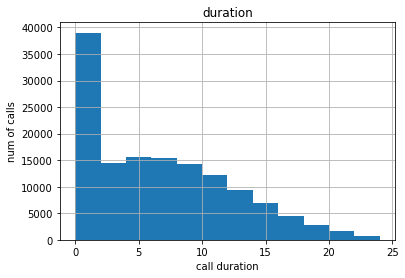

In [11]:
calls.hist('duration', bins=12, range=(0,24))
# mean + 3 * std = 24. Although its not normal distribution,
# but as its skewed considerably to the left its easy to see graphically that 24 as a top margin is fine
plt.title('duration')
plt.ylabel('num of calls')
plt.xlabel('call duration')
plt.show()

Strange thing concerning the `id` column is noted - it seems there are missing calls from the data. The full data might be reached, to find out whats the deal. It might be calls made by customers who dont belong to the 500 customers reviewed, and therefore not relevant for this analysis.
From the histogram its easy to see there are a lot of short/missed calls. If those calls are missed they wont add up to some positive duration so they wont effect the revenue analyzed. If those are just very short calls, they would be summed to some positive duration in the lines to come thus will effect the revenue as they should

As the customer is charged for the duration rounded up, it'll be better to reflect it in advance in the data:

In [12]:
calls.duration = np.ceil(calls['duration']).astype('int64') #its ints anyway

### Proportion of Missed Calls <a id="pmc"></a>

In [13]:
calling_users = calls['user_id'].unique()
print('number of calling users -',(len(calling_users)))
missed_calls = calls.query('duration == 0')
print('% of missed calls -', len(missed_calls) / len(calls) * 100, end='')
print('%')
miss_users = missed_calls['user_id'].unique()
print('number of miss-calling users -',len(miss_users))

number of calling users - 481
% of missed calls - 19.482339274694162%
number of miss-calling users - 478


About 20% of calls are missed, and the company doesn't charge them.
Less than 1% of calling clients didn't had missing calls, so it's pretty common.
By keeping those missed calls it'll be easier to make further research as to the effect of missed calls on other user criterias.

In [14]:
# adding month column in order to group the data by user monthly records later
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

# preparing auxilary data frame for later calculating revenue
# the duration is summed, to get the total call use, and counted to get total number of calls
df_calls = calls.groupby(['user_id','month'])['duration'].agg(['sum','count'])
df_calls = df_calls.rename({'sum': 'duration', 'count': 'calls'}, axis=1).add_suffix('').reset_index()
df_calls

,user_id,month,duration,calls
0,1000,12,124,16
1,1001,8,182,27
2,1001,9,315,49
3,1001,10,393,65
4,1001,11,426,64
...,...,...,...,...
2253,1498,12,339,39
2254,1499,9,346,41
2255,1499,10,385,53
2256,1499,11,308,45


In [15]:
df_calls.month.value_counts()

12    460
11    403
10    337
9     277
8     230
7     179
6     141
5     104
4      71
3      35
2      15
1       6
Name: month, dtype: int64

It seems most of the calls are from Decemeber, and that the number of calls per month has been rising steeply through the year.

## `internet` <a id="int"></a>

In [16]:
internet.session_date = internet.session_date.astype('datetime64[M]')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [17]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-01,89.86
1,1000_204,1000,2018-12-01,0.00
2,1000_379,1000,2018-12-01,660.40
3,1000_413,1000,2018-12-01,270.99
4,1000_442,1000,2018-12-01,880.22


In [18]:
internet.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [19]:
internet[internet['id'] == 'None']

,id,user_id,session_date,mb_used


In [20]:
internet[internet['session_date'] == 'None']

,id,user_id,session_date,mb_used


In [21]:
internet.duplicated().sum()

0

No missing or duplicated values

In [22]:
internet.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


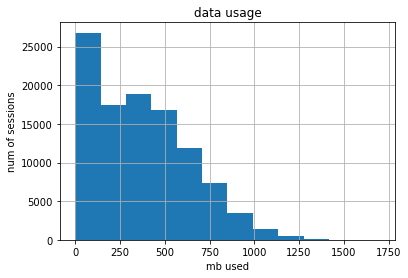

In [23]:
internet.hist('mb_used', bins=12, range=(0,1700)) #1700 = max value
plt.title('data usage')
plt.ylabel('num of sessions')
plt.xlabel('mb used')
plt.show()

The histogram clearly shows the "popularity" of short sessions. It makes sense - chats in a lot of apps are performed in sessions. Checking for directions, weather and premier league results are all short sessions

### Proportion of Missed Connections <a id="pomconc"></a>

In [24]:
internet_users = internet['user_id'].unique()
print('number of internet users -',(len(internet_users)))
missed_connection = internet.query('mb_used == 0')
print('% of missed connections -',len(missed_connection) / len(internet) * 100)

# users who experienced missed connections
miss_connect_users = missed_connection['user_id'].unique()
print('number of miss connect users -',len(miss_connect_users))

number of internet users - 489
% of missed connections - 13.11423801574052
number of miss connect users - 477


About 13% are missed connections. Megaline doesn't charge them.
(489-477)/489 = 2.5% of internet clients didn't had missed connections, so it's pretty common.
By keeping those missed connections it'll be easier to make further research as to the effect of missed connections on other user criterias. Anyway, keeping them wont affect monthly fees.

Some of those "failed" connections (or all of them) can be valid connnections only too small to be logged by the server. The distribution of those cases between the "failed" connections is unknown.
But, as 13% and 20% are roughly the same size, its not completely useless to keep those failed connections.

In [25]:
# again, adding month column for further analysis
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [26]:
# preparing auxilary data frame for later calculating revenue

tmp = internet.groupby(['user_id','month'])['mb_used'].sum() / 1024
# we ceil the outcome as a customer pays for a full GB for every part it uses of it (monthly). 
df_data = tmp.apply(np.ceil)

# again, for later analysis its better to transform the groupby's indexes and duration column to 3 columns in a
#"normal" indexed data frame
df_data = df_data.to_frame()

# earlier we divided mb_used by 1024 and rounded up the monthly sum, thus calculating gb_user per month per customer 
df_data = df_data.rename({'mb_used': 'gb'}, axis=1).add_suffix('').reset_index()
df_data['gb'] = df_data['gb'].astype('int64')
df_data

,user_id,month,gb
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19
...,...,...,...
2272,1498,12,23
2273,1499,9,13
2274,1499,10,20
2275,1499,11,17


In [27]:
internet.month.value_counts()

12    23492
11    18651
10    16193
9     12722
8     10718
7      8110
6      6057
5      4288
4      2558
3      1336
2       604
1        96
Name: month, dtype: int64

Again, customer usage kept rising through the year.

## `messages` <a id="mess"></a>

In [28]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [29]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [30]:
messages.message_date = messages.message_date.astype('datetime64[M]')

In [31]:
messages['user_id'].isna().sum()

0

In [32]:
messages[messages['id'] == 'None']

,id,user_id,message_date


In [33]:
messages[messages['message_date'] == 'None']

,id,user_id,message_date


In [34]:
messages.duplicated().sum()

0

In [35]:
len(messages.user_id.unique())

402

98 users, almost 20% of the reviewed users - don't send SMS's at all.

In [ ]:
messages.month.value_counts()

And again customer usage kept rising

## SMS per Month per User <a id="smspmpu"></a>

Adding a month column will ease the analysis. `df_sms` is presented as an auxiliary df for displaying sms's per month per user

In [36]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

# get the total messages per month per user
df_sms = messages.groupby(['user_id','month'])['id'].count()

df_sms = df_sms.to_frame().rename({'id': 'sms'}, axis=1).add_suffix('').reset_index()
df_sms

,user_id,month,sms
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


## `plans` <a id="plans"></a>

In [38]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [39]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [40]:
plans.plan_name = plans.plan_name.astype('string')

## `users` <a id="users"></a>

In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [42]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [44]:
users['reg_date'] = users['reg_date'].astype('datetime64[M]')

# changing names to strings
users['first_name'] = users['first_name'].astype('string')
users['last_name'] = users['last_name'].astype('string')
users['plan'] = users['plan'].astype('string')
users['city'] = users['city'].astype('string')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    string        
 2   last_name   500 non-null    string        
 3   age         500 non-null    int64         
 4   city        500 non-null    string        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    string        
 7   churn_date  34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(1), string(4)
memory usage: 31.4+ KB


In [45]:
users2 = users.drop(labels='churn_date',axis=1)
users2
users2.duplicated().sum()

0

No duplicates

In [46]:
users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: Int64

Each user has a plan (339+161=500)

In [47]:
users['plancat'] = users['plan'].map(lambda x: 0 if x == 'surf' else 1)

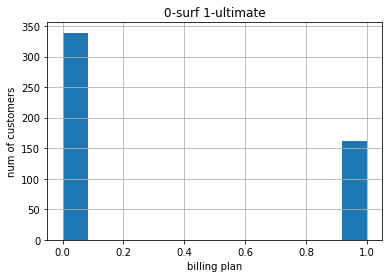

In [48]:
users.hist('plancat', bins=12, range=(0,1))
plt.title('0-surf 1-ultimate')
plt.ylabel('num of customers')
plt.xlabel('billing plan')
plt.show()

The histogram illustrates that surf customers are far more common than ultimate customers. For the sake of this analysis, it'll be better if in reality this is the custumer distribution between billing plans. Otherwise, results of this analysis will be 'skewed' towards surf customers and should be treated carefully, remembering the validity of conclusions is more concerned with the surf clients

In [49]:
users['month'] = pd.DatetimeIndex(users['reg_date'].astype('datetime64[M]')).month
i = users['month'].value_counts().sort_index()
i

1     49
2     42
3     40
4     45
5     38
6     54
7     36
8     47
9     32
10    42
11    38
12    37
Name: month, dtype: int64

Now its clearer. Users gradually joined the company's services at around a fix rate of 40 users per month. So naturally total usage had been rising as well. One thing that's still not clear is that while each of the usage parameters seemed to 'accelerate' as the months passed, the number of registered users went up only linearly

# Revenue <a id="rev"></a>

## Revenue per User per Month <a id="revpupm"></a>

In [50]:
data_frames = [df_calls,df_sms,df_data]
chart = reduce(lambda left,right: pd.merge(left,right,on=['user_id','month'],how='outer'),data_frames).fillna(0)
print(len(chart))
chart

2293


,user_id,month,duration,calls,sms,gb
0,1000,12,124.0,16.0,11.0,2.0
1,1001,8,182.0,27.0,30.0,7.0
2,1001,9,315.0,49.0,44.0,14.0
3,1001,10,393.0,65.0,53.0,22.0
4,1001,11,426.0,64.0,36.0,19.0
...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13.0
2289,1361,5,0.0,0.0,2.0,2.0
2290,1482,10,0.0,0.0,2.0,0.0
2291,1108,12,0.0,0.0,0.0,1.0


In [51]:
print(len(chart.user_id.unique()))
chart = pd.merge(left = chart, right = users[['user_id','plan','city']], how='outer',on='user_id').fillna(0)
print(len(chart.user_id.unique()))
# it appears 10 users didn't use their phone at all. otherwise they would've been in the chart before the latter 
# merging took place.
# users contains data on all the 500 users

490
500


In [52]:
chart

,user_id,month,duration,calls,sms,gb,plan,city
0,1000,12.0,124.0,16.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8.0,182.0,27.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9.0,315.0,49.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10.0,393.0,65.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11.0,426.0,64.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2298,1307,0.0,0.0,0.0,0.0,0.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2299,1319,0.0,0.0,0.0,0.0,0.0,surf,"Colorado Springs, CO MSA"
2300,1378,0.0,0.0,0.0,0.0,0.0,surf,"Denver-Aurora-Lakewood, CO MSA"
2301,1463,0.0,0.0,0.0,0.0,0.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"


In [53]:
# for some reason ints turned to floats
for col in ['month','duration','calls','sms','gb']:
    chart[col] = chart[col].astype('int64')
chart

,user_id,month,duration,calls,sms,gb,plan,city
0,1000,12,124,16,11,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,182,27,30,7,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,315,49,44,14,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,393,65,53,22,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,426,64,36,19,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2298,1307,0,0,0,0,0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2299,1319,0,0,0,0,0,surf,"Colorado Springs, CO MSA"
2300,1378,0,0,0,0,0,surf,"Denver-Aurora-Lakewood, CO MSA"
2301,1463,0,0,0,0,0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"


In [54]:
chart.tail(20)

,user_id,month,duration,calls,sms,gb,plan,city
2283,1194,9,0,0,76,37,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA"
2284,1194,10,0,0,88,31,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA"
2285,1194,11,0,0,62,42,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA"
2286,1194,12,0,0,56,31,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA"
2287,1204,11,0,0,42,21,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2288,1204,12,0,0,78,36,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,10,0,0,76,13,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,11,0,0,72,17,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,12,0,0,61,13,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2292,1108,12,0,0,0,1,ultimate,"Salt Lake City, UT MSA"


indeed the table makes sense, only last 10 rows are completely empty

## Cost Function <a id="cf"></a>

In [55]:
def cost(row):
    duration=row['duration']
    sms = row['sms']
    gb = row['gb']
    plan = row['plan']
    if plan == 'ultimate':
        fee = 70
        if duration > 3000:
            fee += (duration - 3000) * 0.01
        if sms > 1000:
            fee += (sms - 1000) * 0.01
        if gb > 30:
            fee += (gb - 30) * 7
    elif plan == 'surf':
        fee = 20
        if duration > 500:
            fee += (duration - 500) * 0.03
        if sms > 50:
            fee += (sms - 50) * 0.03
        if gb > 15:
            fee += (gb - 15) * 10
    
    return fee

## Revenue Table <a id="rvtbl"></a>

In [56]:
chart['revenue'] = chart.apply(cost,axis=1)
chart # how to do this using dicts and plans file?

,user_id,month,duration,calls,sms,gb,plan,city,revenue
0,1000,12,124,16,11,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,182,27,30,7,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,315,49,44,14,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,393,65,53,22,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,426,64,36,19,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00
...,...,...,...,...,...,...,...,...,...
2298,1307,0,0,0,0,0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.00
2299,1319,0,0,0,0,0,surf,"Colorado Springs, CO MSA",20.00
2300,1378,0,0,0,0,0,surf,"Denver-Aurora-Lakewood, CO MSA",20.00
2301,1463,0,0,0,0,0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00


In [57]:
chart.duplicated().sum()

0

## Seperating Charts by Locations and Creating Revenue Serieses per Area <a id="sclcrsa"></a>

In [58]:
chart_NY_NJ = chart[chart['city'].str.contains("NY-NJ")]
chart_NY_NJ

,user_id,month,duration,calls,sms,gb,plan,city,revenue
56,1014,11,163,28,9,2,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",20.00
57,1014,12,1114,150,64,8,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",38.84
75,1022,5,302,39,0,5,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",20.00
76,1022,6,490,76,0,23,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",100.00
77,1022,7,475,70,0,10,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",20.00
...,...,...,...,...,...,...,...,...,...
2264,1080,9,0,0,64,25,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",120.42
2265,1080,10,0,0,59,30,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",170.27
2266,1080,11,0,0,50,33,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",200.00
2267,1080,12,0,0,61,24,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",110.33


In [59]:
chart_rest = chart.drop(chart_NY_NJ.index)
chart_rest

,user_id,month,duration,calls,sms,gb,plan,city,revenue
0,1000,12,124,16,11,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,182,27,30,7,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,315,49,44,14,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,393,65,53,22,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,426,64,36,19,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00
...,...,...,...,...,...,...,...,...,...
2298,1307,0,0,0,0,0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.00
2299,1319,0,0,0,0,0,surf,"Colorado Springs, CO MSA",20.00
2300,1378,0,0,0,0,0,surf,"Denver-Aurora-Lakewood, CO MSA",20.00
2301,1463,0,0,0,0,0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00


In [60]:
revenue_NY_NJ = chart_NY_NJ['revenue']
revenue_rest = chart_rest['revenue']
var1 = np.var(revenue_rest)
var2 = np.var(revenue_NY_NJ)
print(var1,var2)

2219.881380131205 1885.7843645817597


Variation of revenue differs between NY/NJ and the rest.
In addition the revenue serieses for the different locations we're extracted.

## Creating Revenue Serieses per Plan <a id="rvspp"></a>

In [61]:
ultimate_chart = chart[chart['plan'] == 'ultimate']
surf_chart = chart[chart['plan'] == 'surf']

ultimate_revenue = ultimate_chart['revenue'].to_frame()
ultimate_revenue

,revenue
0,70.0
19,70.0
20,84.0
26,70.0
27,70.0
...,...
2292,70.0
2293,70.0
2296,70.0
2297,70.0


In [62]:
surf_revenue = surf_chart['revenue'].to_frame()
surf_revenue

,revenue
1,20.00
2,20.00
3,90.09
4,60.00
5,60.00
...,...
2295,20.00
2298,20.00
2299,20.00
2300,20.00


# Plan Analysis <a id="plalys"></a>

## Revenue per Plan <a id="rvprpl"></a>

In [63]:
tmp = chart.groupby('plan')['revenue'].describe()
tmp['var'] = tmp['std']*tmp['std']
tmp

,count,mean,std,min,25%,50%,75%,max,var
plan,,,,,,,,,
surf,1579.0,60.551729,55.339379,20.0,20.0,40.18,80.315,590.37,3062.446864
ultimate,724.0,72.301105,11.364839,70.0,70.0,70.00,70.000,182.00,129.159556


There are a few things to notice about the latter table -

- Surf mean is relatively close to the ultimate mean. thus, customers who take the cheaper plan end up paying twice the basic fee more on service beyond the plan basic services.

- Surf plan users are more dispersed, as their std is 5 times bigger while their values are generally smaller.
the max values are example of that

- At least 75% of the ultimate customers don't pay for more than the basic service.

- At least 50% of the surf customers need more than basic services but still pay just 40$.

- The variations are not equal or close to

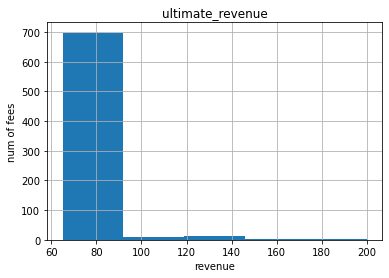

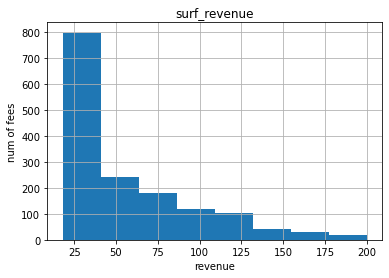

In [64]:
ultimate_chart.hist('revenue', bins=5, range=(65,200))
plt.title('ultimate_revenue')
plt.ylabel('num of fees')
plt.xlabel('revenue')
plt.show()

surf_chart.hist('revenue', bins=8, range=(18,200))
plt.title('surf_revenue')
plt.ylabel('num of fees')
plt.xlabel('revenue')
plt.show()

The most common fees are the basic fees for each plan. There's a bigger variation in the surf customers data

## Duration per Plan <a id="drtprpl"></a>

In [65]:
tmp = chart.groupby('plan')['duration'].describe()
tmp['var'] = tmp['std']*tmp['std']
tmp

,count,mean,std,min,25%,50%,75%,max,var
plan,,,,,,,,,
surf,1579.0,427.120329,235.490079,0.0,269.00,424.0,576.00,1510.0,55455.577400
ultimate,724.0,428.071823,241.958423,0.0,258.75,421.5,564.25,1369.0,58543.878652


Duration almost the same in the 2 plans! It implies users use their phone the same irrelevant of their plan, at least when it comes to phone calls.

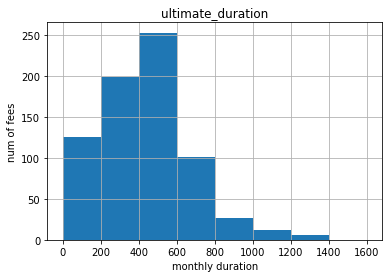

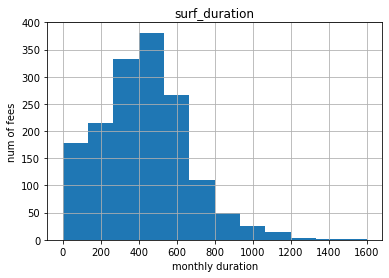

In [66]:
ultimate_chart.hist('duration', bins=8, range=(0,1600))
plt.title('ultimate_duration')
plt.ylabel('num of fees')
plt.xlabel('monthly duration')
plt.show()

surf_chart.hist('duration', bins=12, range=(0,1600))
plt.title('surf_duration')
plt.ylabel('num of fees')
plt.xlabel('monthly duration')
plt.show()

As witnessed in "Duration per plan", the data for the different plans is almost statistically identical, and hence the histograms have the same general shape.

## SMS per Plan <a id="smsprpl"></a>

In [67]:
tmp = chart.groupby('plan')['sms'].describe()
tmp['var'] = tmp['std']*tmp['std']
tmp

,count,mean,std,min,25%,50%,75%,max,var
plan,,,,,,,,,
surf,1579.0,31.041165,33.557683,0.0,3.0,24.0,47.00,266.0,1126.118076
ultimate,724.0,37.343923,34.782576,0.0,6.0,30.0,60.25,166.0,1209.827612


Ultimate plan users message more.

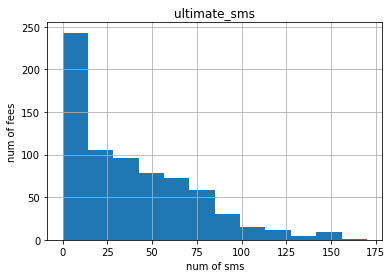

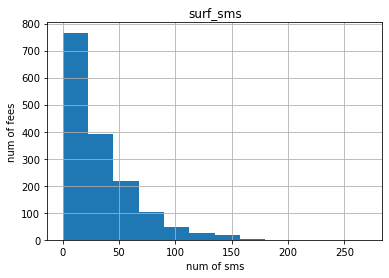

In [68]:
ultimate_chart.hist('sms', bins=12, range=(0,170))
plt.title('ultimate_sms')
plt.ylabel('num of fees')
plt.xlabel('num of sms')
plt.show()

surf_chart.hist('sms', bins=12, range=(0,270))
plt.title('surf_sms')
plt.ylabel('num of fees')
plt.xlabel('num of sms')
plt.show()

As seen in "SMS per plan", the mean is greater than the median for both plans, and hence the right-skewed histograms. It seems ultimate users messgae more than their surf friends.

## GB per Plan <a id="gbprp"></a>

In [69]:
tmp = chart.groupby('plan')['gb'].describe()

tmp['var'] = tmp['std']*tmp['std']
tmp

,count,mean,std,min,25%,50%,75%,max,var
plan,,,,,,,,,
surf,1579.0,16.607346,7.899502,0.0,12.0,17.0,21.0,70.0,62.402126
ultimate,724.0,17.211326,7.755841,0.0,13.0,17.0,21.0,46.0,60.153067


Usage almost identical. Again there's a surf user with record breaking usage, but his not the majority.
The data implies again that users use their phone the same irrelevant of their plan.

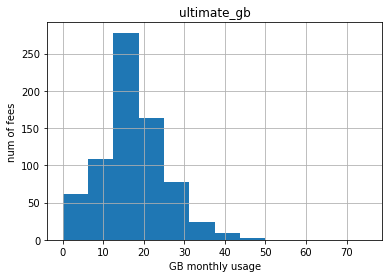

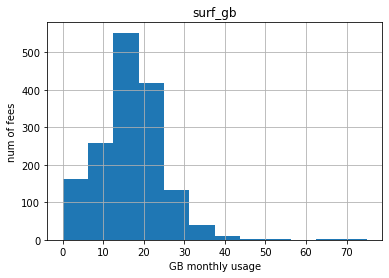

In [70]:
ultimate_chart.hist('gb', bins=12, range=(0,75))
plt.title('ultimate_gb')
plt.ylabel('num of fees')
plt.xlabel('GB monthly usage')
plt.show()

surf_chart.hist('gb', bins=12, range=(0,75))
plt.title('surf_gb')
plt.ylabel('num of fees')
plt.xlabel('GB monthly usage')
plt.show()

As witnessed in "GB per plan", the data for the different plans is almost statistically identical, and hence the histograms have the same general shape.

# Hypotheses <a id="hyp"></a>

<b>H0: the revenue means for the two Megaline plans are equal
    
   H1: the revenue means for the two Megaline plans differ</b>

In [71]:
# test the null hypothesis - the revenue means for the two Megaline plans are equal
alpha = 0.05

results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: [1.21841159e-15]
We reject the null hypothesis


The null hypotheses is strongly as it gets rejected, as p-value is very small. Thus, the alternative hypotheses - <b>the averages differ</b> - is pretty likely to be true

<b>H0: the revenue means for NY-NJ and all other areas are equal
    
   H1: the revenue means for NY-NJ and all other areas differ</b>

In [72]:
# test the null hypothesis - the revenue means for NY-NJ and all other areas are equal
alpha = 0.05

results = st.ttest_ind(revenue_NY_NJ, revenue_rest, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.03870322661292944
We reject the null hypothesis


The null hypotheses is rejected, as p-value is small. Thus, the alternative hypotheses - <b>the averages differ</b> - is more likely. Though, in this case neither conclusion is strong as p-value is around the size of alpha.

# Conclusion <a id="conc"></a>

Both plans donate their part to the revenue - the majority of users from both plans pay around the basic fee of their plan every month, and while surf basic fee is 3 times cheaper than ultimate's basic fee, there're 3 times more surf customers, and if thats a reflection of reality its important for the company to have a cheap popular plan, especially if it turns out the median surf user pays 40$ per month, twice the plan's basic fee.

A considerable amount of surf customers (more than 25% of them) bring the company the same revenue as ultimate customers do and even more.

A lot of surf customers who pass their basic service are still paying less than the basic price for the ultimate plan. Therefore they less prone for changing their plan to ultimate. On the other hand, those surf customers who pass their monthly basic service and end up paying more than the basic fee for the ultimate plan are actually the best customers the company has - they take less of the company's assets and end up paying more for them. And as mentioned they're not a minority - more than 25% of surf customers end up paying more than the ultimate customers, making them the most profitable subset of clients.
So, when advertising for the ultimate plan its good to keep in mind the company need to preserve those high paying surf customers.

The median user from either plan is pretty identical - 17 GB of data, 30 SMS and 420 minutes of calls per month.
Both plans supply more than enough minutes and SMS's for the median user - so users who choose ultimate over surf probably do it for the extra data usage they get.

Usage of every parameter of the company's service plans rised along the year steeply, while number of registered users rised linearly. That suggests average usage per user rised as well through the year.

Outliers were'nt handled because they're not defined well - a user gb usage can be an outlier, while his call duration and sms usage is normal. In such a case, removing the gb usage outlier will result in faulty calculation of the user's revenue.